In [ ]:
# STEP 1: Install Detectron2 & dependencies
!pip install -q torch torchvision torchaudio
!pip install -q git+https://github.com/facebookresearch/detectron2.git
!pip install -q opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open vehide-dataset-automatic-vehicle-damage-detection.zip, vehide-dataset-automatic-vehicle-damage-detection.zip.zip or vehide-datas

In [ ]:
# ✅ Core Libraries
import os
import json
import shutil
import random
from PIL import Image

# ✅ Detectron2 Core
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

# ✅ Data Management
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer

# ✅ Visualization
import cv2
import matplotlib.pyplot as plt

In [ ]:
# STEP 2: Mount Kaggle to download dataset
from google.colab import files
files.upload()  # ⬆️ Upload your kaggle.json file here

# Move API key to correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection
!unzip -q vehide-dataset-automatic-vehicle-damage-detection.zip -d vehide_data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection
License(s): apache-2.0


In [ ]:
# Redefine all required paths
train_ann_path = "/content/vehide_data/0Train_via_annos.json"
val_ann_path = "/content/vehide_data/0Val_via_annos.json"
train_img_dir = "/content/vehide_data/image/image"
val_img_dir = "/content/vehide_data/validation/validation"
output_dir = "./detectron_dataset"

# Ensure class mapping and output directories are still defined
CLASSES = {
    'mat_bo_phan': 0,
    'rach': 1,
    'mop_lom': 2,
    'tray_son': 3,
    'thung': 4,
    'vo_kinh': 5,
    'be_den': 6
}

for sub in ['train', 'val', 'annotations']:
    os.makedirs(os.path.join(output_dir, sub), exist_ok=True)


In [ ]:
def convert_via_to_coco(via_json_path, img_dir, output_img_dir, output_json_path):
    with open(via_json_path) as f:
        via_data = json.load(f)

    coco_output = {
        "images": [],
        "annotations": [],
        "categories": [{"id": v, "name": k} for k, v in CLASSES.items()]
    }

    ann_id = 1
    for img_id, (filename, file_data) in enumerate(via_data.items(), 1):
        img_path = os.path.join(img_dir, filename)
        if not os.path.exists(img_path):
            continue

        # Copy image to output directory
        shutil.copy(img_path, os.path.join(output_img_dir, filename))

        # Get image dimensions
        with Image.open(img_path) as im:
            width, height = im.size

        coco_output["images"].append({
            "id": img_id,
            "file_name": filename,
            "width": width,
            "height": height
        })

        for region in file_data.get('regions', []):
            cls_name = region.get('class')
            if cls_name not in CLASSES:
                continue

            cls_id = CLASSES[cls_name]
            all_x = region['all_x']
            all_y = region['all_y']

            if len(all_x) < 3 or len(all_x) != len(all_y):
                continue

            # Segmentation format: [x1, y1, x2, y2, ...]
            segmentation = [[float(x) for pair in zip(all_x, all_y) for x in pair]]
            x_min = min(all_x)
            y_min = min(all_y)
            x_max = max(all_x)
            y_max = max(all_y)
            box_w = x_max - x_min
            box_h = y_max - y_min

            annotation = {
                "id": ann_id,
                "image_id": img_id,
                "category_id": cls_id,
                "segmentation": segmentation,
                "bbox": [x_min, y_min, box_w, box_h],
                "area": box_w * box_h,
                "iscrowd": 0
            }
            coco_output["annotations"].append(annotation)
            ann_id += 1

    with open(output_json_path, 'w') as f:
        json.dump(coco_output, f, indent=2)

In [ ]:
# Retry conversion after confirming file paths

convert_via_to_coco(
    train_ann_path,
    train_img_dir,
    f"{output_dir}/train",
    f"{output_dir}/annotations/instances_train.json"
)

convert_via_to_coco(
    val_ann_path,
    val_img_dir,
    f"{output_dir}/val",
    f"{output_dir}/annotations/instances_val.json"
)

In [ ]:
from detectron2.data.datasets import register_coco_instances

# Register your converted datasets with Detectron2
register_coco_instances(
    "vehicle_damage_train",
    {},
    "./detectron_dataset/annotations/instances_train.json",
    "./detectron_dataset/train"
)

register_coco_instances(
    "vehicle_damage_val",
    {},
    "./detectron_dataset/annotations/instances_val.json",
    "./detectron_dataset/val"
)

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()

# Load base Mask R-CNN model config
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
))

# Dataset names as registered above
cfg.DATASETS.TRAIN = ("vehicle_damage_train",)
cfg.DATASETS.TEST = ("vehicle_damage_val",)

cfg.DATALOADER.NUM_WORKERS = 2

# Pretrained model weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # You can tune this later
cfg.SOLVER.MAX_ITER = 5000    # Number of training iterations
cfg.SOLVER.STEPS = []         # Disable learning rate decay
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7  # Set based on your classes

# Output folder
cfg.OUTPUT_DIR = "./detectron_output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
from detectron2.engine import DefaultTrainer
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Initialize and train
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/14 00:07:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[04/14 00:07:20 d2.engine.train_loop]: Starting training from iteration 0
[04/14 00:07:30 d2.utils.events]:  eta: 0:36:50  iter: 19  total_loss: 3.33  loss_cls: 1.882  loss_box_reg: 0.5609  loss_mask: 0.6936  loss_rpn_cls: 0.1305  loss_rpn_loc: 0.03405    time: 0.4424  last_time: 0.3784  data_time: 0.0282  last_data_time: 0.0157   lr: 4.9953e-06  max_mem: 3087M
[04/14 00:07:39 d2.utils.events]:  eta: 0:36:34  iter: 39  total_loss: 3.139  loss_cls: 1.757  loss_box_reg: 0.4636  loss_mask: 0.6924  loss_rpn_cls: 0.2142  loss_rpn_loc: 0.02823    time: 0.4420  last_time: 0.4374  data_time: 0.0104  last_data_time: 0.0181   lr: 9.9902e-06  max_mem: 3088M
[04/14 00:07:47 d2.utils.events]:  eta: 0:36:00  iter: 59  total_loss: 2.773  loss_cls: 1.522  loss_box_reg: 0.3281  loss_mask: 0.6906  loss_rpn_cls: 0.134  loss_rpn_loc: 0.0292    time: 0.4336  last_time: 0.3973  data_time: 0.0108  last_data_time: 0.0068   lr: 1.4985e-05  max_mem: 3088M
[04/14 00:07:55 d2.utils.events]:  eta: 0:35:43  iter: 7

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Setup evaluator for validation dataset
evaluator = COCOEvaluator("vehicle_damage_val", cfg, False, output_dir="./detectron_eval")
val_loader = build_detection_test_loader(cfg, "vehicle_damage_val")

# Run inference and print evaluation results
print("\n🔍 Running validation set evaluation...\n")
metrics = inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [04/14 00:44:33 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/14 00:44:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/14 00:44:33 d2.data.datasets.coco]: Loaded 2324 images in COCO format from ./detectron_dataset/annotations/instances_val.json
[04/14 00:44:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/14 00:44:34 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/14 00:44:34 d2.data.common]: Serializing 2324 elements to byte tensors and concatenating them all ...
[04/14 00:44:34 d2.data.common]: Serialized dataset takes 2.74 MiB

🔍 Running validation set evaluation...

[04/14 00:44:34 d2.evaluation.evaluator]: Start inf

[04/14 01:01:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./detectron_output/model_final.pth ...


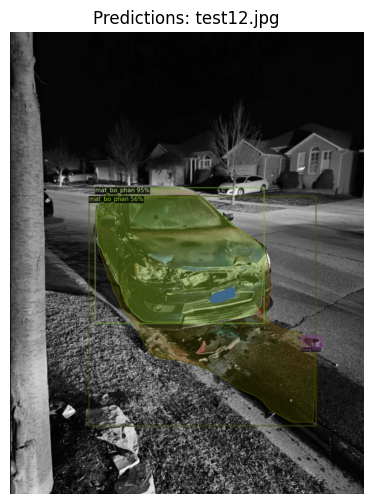

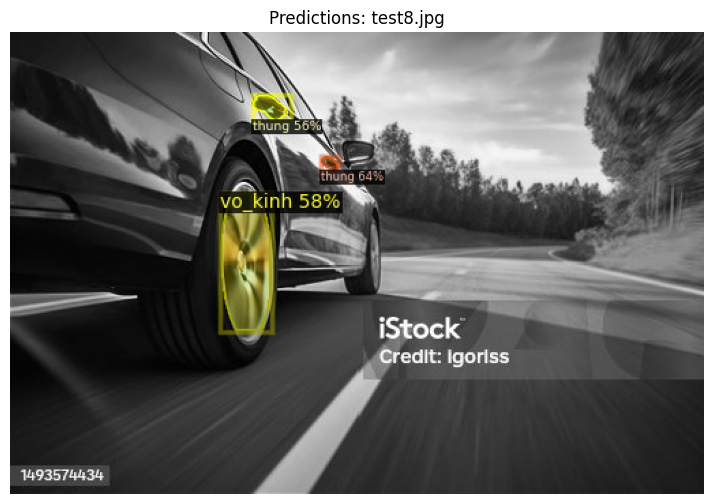

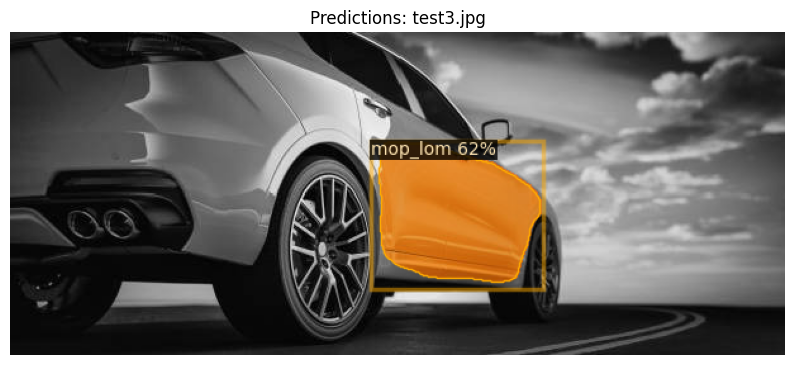

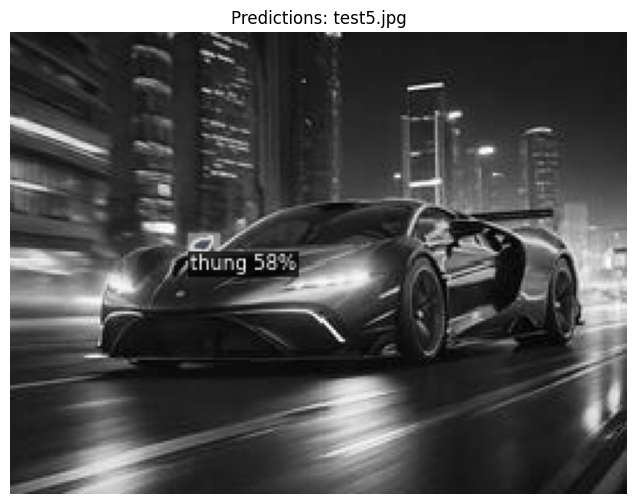

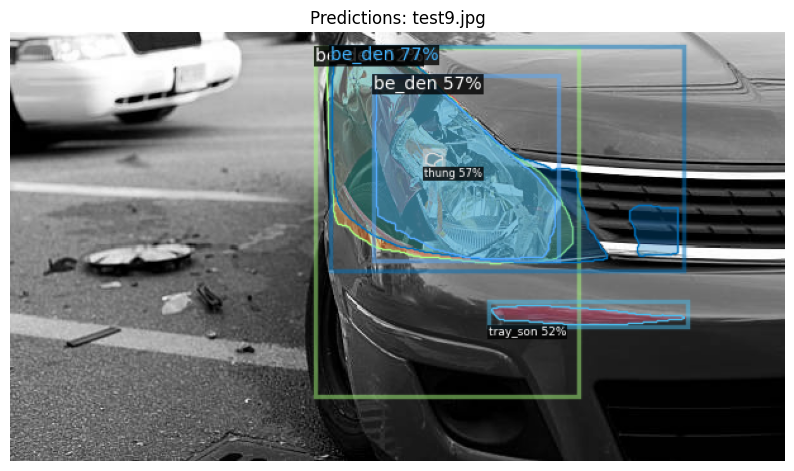

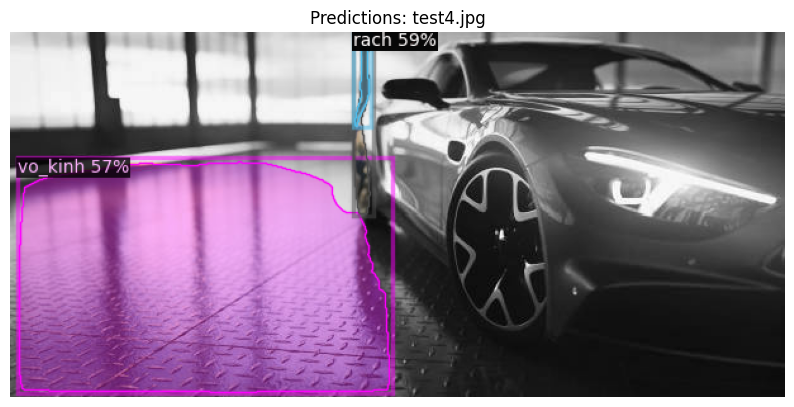

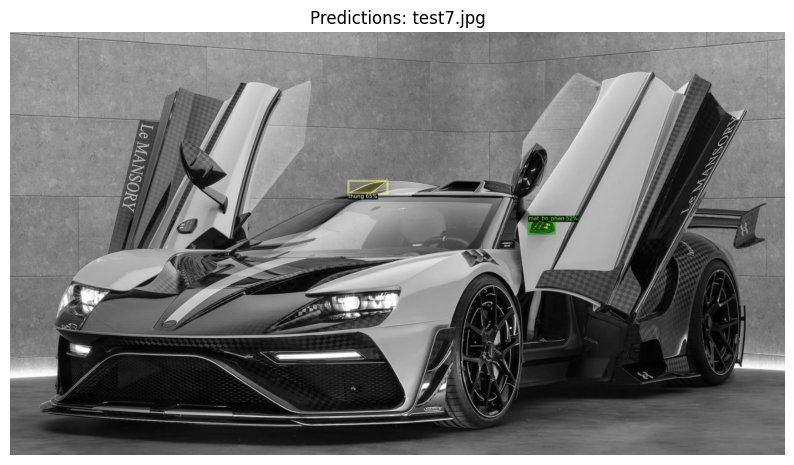

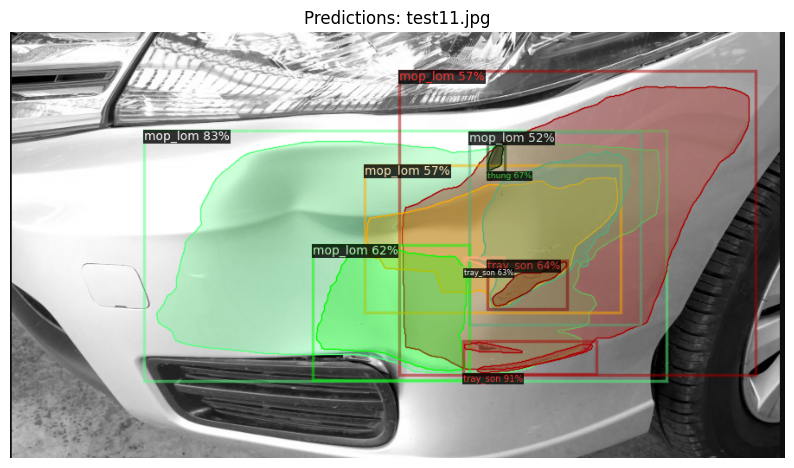

In [ ]:
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
import os

# Load trained model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Confidence threshold
predictor = DefaultPredictor(cfg)

# Metadata
metadata = MetadataCatalog.get("vehicle_damage_train")

# Prediction directory
pred_dir = "/content/predictions"
images = [img for img in os.listdir(pred_dir) if img.lower().endswith(('.jpg', '.png'))]

# Run prediction and visualize
for img_name in images:
    img_path = os.path.join(pred_dir, img_name)
    im = cv2.imread(img_path)

    outputs = predictor(im)

    v = Visualizer(
        im[:, :, ::-1],  # Convert BGR to RGB
        metadata=metadata,
        scale=1.0,
        instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Display
    plt.figure(figsize=(10, 6))
    plt.imshow(out.get_image())
    plt.title(f"Predictions: {img_name}")
    plt.axis("off")
    plt.show()